In [3]:
from glob import glob
import numpy as np
import pandas as pd

### Create the training dataset

In [7]:
# Extract the subjects' label.
path_labels = '../data/risk_golden_truth.txt'
labels = {}
with open(path_labels, 'r') as f:
    for line in f:
        subject, label = line.split()
        labels[subject] = int(label)

In [ ]:
def create_dataset():
   # Create the train dataset from the subjects' posts and label.
   txt_path = glob('../data/processed/*')
   rows_data = []
   for path in txt_path:
      with open(path, 'r+') as f:
         # Split the path, get the filename 
         # (which contains the subject) and remove '.txt'
         subject = path.split('\\')[1][:-4] 
         txt = f.read()
         rows_data.append((subject, txt, labels[subject]))

   # Training dataset.
   train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])
   return train_data

In [ ]:
train_data = create_dataset()

In [ ]:
train_data

### Preprocess the subjects' posts
Text normalization techniques:
- lowercasing 
- whitespace removal
- URL removal
- tokenization
- stopwords removal
- punctuation removal
- stemming

In [28]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

In [ ]:
# Normalize all words to lowercase.
train_data["Text"] = train_data["Text"].str.lower()

In [27]:
def remove_whitespace(text):
   """ Removes all whitespaces from a given text."""
   return " ".join(text.split())

In [ ]:
# Remove all whitespaces from texts.
train_data["Text"] = train_data["Text"].apply(remove_whitespace)

In [26]:
def remove_URLs(text):
   "Remove URLs from text using regular expressions."
   url_re = re.compile(r'https?://\S+|www\.\S+')
   return url_re.sub(r'', text)

In [ ]:
train_data["Text"][2][:200]

In [ ]:
# Remove URLs from texts.
train_data["Text"] = train_data["Text"].apply(remove_URLs)

In [ ]:
train_data["Text"][2][:200]

In [ ]:
# Extract tokens from texts.
train_data["Text"] = train_data["Text"].apply(lambda x: word_tokenize(x))

In [25]:
def remove_punctuation(text):
   tokenizer = RegexpTokenizer(r'\w+')
   no_punct = tokenizer.tokenize(" ".join(text))
   return no_punct

In [ ]:
# Removes punctuation from texts.
train_data["Text"] = train_data["Text"].apply(remove_punctuation)

In [24]:
en_stopwords = stopwords.words('english')
def remove_stopwords(text):
   """Removes english stopwords."""
   result = []
   for token in text:
      if token not in en_stopwords:
         result.append(token)

   return result

In [ ]:
# Removes stopwords from texts.
train_data["Text"] = train_data["Text"].apply(remove_stopwords)

In [23]:
def stemming(text):
   porter = PorterStemmer()
   result = []
   for word in text:
      result.append(porter.stem(word))

   return result

In [ ]:
# Apply stemming to words from texts.
train_data["Text"] = train_data["Text"].apply(stemming)

In [ ]:
# Save the dataset to a .csv file.
train_data.to_csv('../data/train_dataset.csv')

### Standard ML approaches

In [22]:
import time
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Load the training dataset.
train_data = pd.read_csv('../data/train_dataset.csv')

In [ ]:
# Visualize the distribution of class labels.
train_data["Label"].value_counts()

In [ ]:
# Visualize the distribution of class labels.
train_data["Label"].value_counts().plot.bar()

### ML experiments
Feature extractors:
- Bag-of-Words
- TF-IDF

Classifiers:
- LinearSVC
- Logistic Regression
- Random Forest
- K-neighbors
- Decision Tree

In [ ]:
X = train_data["Text"]
y = train_data["Label"]

In [38]:
# Feature extractors.
feature_extractors = [
CountVectorizer(),
TfidfVectorizer(),
# Ignore words that appear in less than 20% of posts (rare words).
CountVectorizer(min_df=0.2),
# Ignore words that appear in more than 80% of posts (frequent words).
CountVectorizer(max_df=0.8),
CountVectorizer(ngram_range=(2, 2)),
CountVectorizer(ngram_range=(3, 3)),
TfidfVectorizer(min_df=0.2),
TfidfVectorizer(max_df=0.8),
TfidfVectorizer(ngram_range=(2, 2)),
TfidfVectorizer(ngram_range=(3, 3))
]

# Classifiers.
classifiers = [ 
# LinearSVC(max_iter=100000), 
# LogisticRegression(max_iter=100000),
KNeighborsClassifier(),
RandomForestClassifier(),
DecisionTreeClassifier()
]

In [40]:
# Use a stratified 5-fold CV to try to reduce
# the class imbalance in train/validation splits.
cv = StratifiedKFold(n_splits=5)

scoring = {
'accuracy': make_scorer(accuracy_score),
'precision': make_scorer(precision_score),
'recall': make_scorer(recall_score),
'f1_score': make_scorer(f1_score)
}

In [21]:
def start_ML_pipeline():
   for classifier in classifiers:
      for extractor in feature_extractors:
         start_time = time.time()
         pipeline = Pipeline([('extractor', extractor), ('classifier', classifier)])
         scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
         end_time = time.time()
         total_time = round((end_time - start_time)/60, 2)
         
         f1_score = round(np.mean(scores['test_f1_score']), 2)
         precision = round(np.mean(scores['test_precision']), 2)
         recall = round(np.mean(scores['test_recall']), 2)
         acc = round(np.mean(scores['test_accuracy']), 2)

         print("Time: ", total_time, " min")
         print("Experiment: ", str(classifier), "+", str(extractor))
         print("F1 score= ", f1_score, ", 5-fold CV=", scores['test_f1_score'])
         print("Precision= ", precision, ", 5-fold CV=", scores['test_precision'])
         print("Recall= ", recall, ", 5-fold CV=", scores['test_recall'])
         print("Accuracy= ", acc, ", 5-fold CV=", scores['test_accuracy'])
         print("="*100)

In [ ]:
start_ML_pipeline()

### Create a dataset with individual posts:
- labeled separately for label=1
- chunks of 20 posts for label=0

In [20]:
def create_dataset_single_posts():
   # Create the train dataset from the subjects' posts and label.
   txt_path = glob('../data/processed/*')
   rows_data = []
   chunks = 20
   for path in txt_path:
      with open(path, 'r+') as f:
         # Split the path, get the filename 
         # (which contains the subject) and remove '.txt'
         subject = path.split('\\')[1][:-4]
         txt = f.read()
         txt = txt.split('\n')
         label = labels[subject]
         i = 0
         chunked_posts = []
         for post in txt:
            # For the posts with label 1, store them individually.
            if label == 1:
               rows_data.append((subject, post, label))
            # For the posts with label 0, form chunks of 20 posts.
            else:
               i +=1
               chunked_posts.append(post)
               if i == chunks:
                  chunked_posts = " ".join(chunked_posts)
                  rows_data.append((subject, chunked_posts, label))
                  chunked_posts = []
                  i = 0

   # Training dataset.
   train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])
   return train_data

In [18]:
def create_dataset_balanced():
   # Create the train dataset from the subjects' posts and label.
   txt_path = glob('../data/processed/*')
   rows_data = []
   max_posts = 25
   for path in txt_path:
      with open(path, 'r+') as f:
         # Split the path, get the filename 
         # (which contains the subject) and remove '.txt'
         subject = path.split('\\')[1][:-4]
         txt = f.read()
         txt = txt.split('\n')
         label = labels[subject]
         i = 0
         for post in txt:
            # For the posts with label 1, store them individually.
            if label == 1:
               rows_data.append((subject, post, label))
            # For the posts with label 0, store only the first 25 posts.
            else:
               i +=1
               if i <= max_posts:
                  rows_data.append((subject, post, label))

   # Training dataset.
   train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])
   return train_data

In [19]:
train_data_bal = create_dataset_balanced()
train_data_bal

,Subject,Text,Label
0,subject1,Vulcan's ultimate landing at max range is so s...,0
1,subject1,Is there any defensive item (physical) viable ...,0
2,subject1,Is it still op? His new passive is a little bi...,0
3,subject1,WOOOOOOOOOOOOOOOH (Thoth ult and me running in...,0
4,subject1,That should be Hachiman the new god right?,0
...,...,...,...
107824,subject9996,ride ginger cat for the fly ride king bee or t...,0
107825,subject9996,I can add a 1 or 2 aussie eggs,0
107826,subject9996,black panter was from the jungle egg,0
107827,subject9996,feel free to dm me or comment your offer for t...,0


In [20]:
train_data_bal["Label"].value_counts()

1    54840
0    52989
Name: Label, dtype: int64

In [21]:
train_data_posts = create_dataset_single_posts()
train_data_posts

,Subject,Text,Label
0,subject1,Vulcan's ultimate landing at max range is so s...,0
1,subject1,Idk if it is broken or not but I've noticed th...,0
2,subject1,Nope. I've been playing normally. I play EU th...,0
3,subject1,How can i rebuild it? Ok thanky you. I'll try ...,0
4,subject1,Oh i didn't know that. Let's hope the new syst...,0
...,...,...,...
107558,subject9996,Cool! Thx for cheering me up :) I try my best ...,0
107559,subject9996,beautiful The Last Guest is my idol How can ...,0
107560,subject9996,Oh dm me it's beautiful it's beautiful unfin...,0
107561,subject9996,Sure Nty can I do an very old doge skateboard ...,0


In [22]:
# Visualize the distribution of class labels.
train_data_posts["Label"].value_counts()

1    54840
0    52723
Name: Label, dtype: int64

<AxesSubplot:>

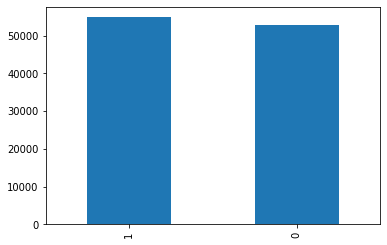

In [23]:
train_data_posts["Label"].value_counts().plot.bar()

In [29]:
# Apply preprocessing on the new dataset.
train_data_bal["Text"] = train_data_bal["Text"].str.lower()

In [30]:
train_data_bal["Text"] = train_data_bal["Text"].apply(remove_whitespace)

In [31]:
train_data_bal["Text"] = train_data_bal["Text"].apply(remove_URLs)

In [32]:
train_data_bal["Text"] = train_data_bal["Text"].apply(lambda x: word_tokenize(x))

In [33]:
train_data_bal["Text"] = train_data_bal["Text"].apply(remove_punctuation)

In [34]:
train_data_bal["Text"] = train_data_bal["Text"].apply(remove_stopwords)

In [35]:
train_data_bal["Text"] = train_data_bal["Text"].apply(stemming)

In [36]:
# Save the dataset to a .csv file.
train_data_bal.to_csv('../data/train_dataset_bal.csv')

In [37]:
# Load the training dataset.
train_data_bal = pd.read_csv('../data/train_dataset_bal.csv')

In [44]:
X = train_data_bal["Text"]
y = train_data_bal["Label"]

# Feature extractors.
feature_extractors = [
CountVectorizer(),
TfidfVectorizer(),
# Ignore words that appear in less than 20% of posts (rare words).
CountVectorizer(min_df=0.2),
# Ignore words that appear in more than 80% of posts (frequent words).
CountVectorizer(max_df=0.8),
CountVectorizer(ngram_range=(2, 2)),
CountVectorizer(ngram_range=(3, 3)),
TfidfVectorizer(min_df=0.2),
TfidfVectorizer(max_df=0.8),
TfidfVectorizer(ngram_range=(2, 2)),
TfidfVectorizer(ngram_range=(3, 3))
]

classifiers = [ 
# LinearSVC(max_iter=100000), 
# LogisticRegression(max_iter=100000),
KNeighborsClassifier(),
DecisionTreeClassifier(),
RandomForestClassifier()
]

In [45]:
start_ML_pipeline()

Time:  3.93  min
Experiment:  KNeighborsClassifier() + CountVectorizer()
F1 score=  0.6 , 5-fold CV= [0.64331495 0.59233998 0.59258867 0.63897828 0.54439732]
Precision=  0.67 , 5-fold CV= [0.70684573 0.69760257 0.7079164  0.71233184 0.52297354]
Recall=  0.55 , 5-fold CV= [0.59026258 0.51467907 0.5095733  0.57932166 0.56765135]
Accuracy=  0.63 , 5-fold CV= [0.6671149  0.63971066 0.64365204 0.66706853 0.51676327]
Time:  4.18  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer()
F1 score=  0.32 , 5-fold CV= [0.31965559 0.30685021 0.30235147 0.35004304 0.31258946]
Precision=  0.58 , 5-fold CV= [0.60954336 0.37827365 0.63799178 0.63948706 0.61922765]
Recall=  0.22 , 5-fold CV= [0.2166302  0.25811451 0.19812181 0.24097374 0.20906273]
Accuracy=  0.51 , 5-fold CV= [0.53102105 0.40693685 0.53500881 0.54488547 0.53234408]


d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\_School\Master AI (2020-2022)\Anul 2\Semestr

Time:  0.16  min
Experiment:  KNeighborsClassifier() + CountVectorizer(min_df=0.2)
F1 score=  nan , 5-fold CV= [nan nan nan nan nan]
Precision=  nan , 5-fold CV= [nan nan nan nan nan]
Recall=  nan , 5-fold CV= [nan nan nan nan nan]
Accuracy=  nan , 5-fold CV= [nan nan nan nan nan]
Time:  3.91  min
Experiment:  KNeighborsClassifier() + CountVectorizer(max_df=0.8)
F1 score=  0.6 , 5-fold CV= [0.64331495 0.59233998 0.59258867 0.63897828 0.54439732]
Precision=  0.67 , 5-fold CV= [0.70684573 0.69760257 0.7079164  0.71233184 0.52297354]
Recall=  0.55 , 5-fold CV= [0.59026258 0.51467907 0.5095733  0.57932166 0.56765135]
Accuracy=  0.63 , 5-fold CV= [0.6671149  0.63971066 0.64365204 0.66706853 0.51676327]
Time:  3.45  min
Experiment:  KNeighborsClassifier() + CountVectorizer(ngram_range=(2, 2))
F1 score=  0.41 , 5-fold CV= [0.60527598 0.16967126 0.49405167 0.43760005 0.34922133]
Precision=  0.63 , 5-fold CV= [0.48947428 0.80557707 0.46260344 0.73499677 0.67011643]
Recall=  0.39 , 5-fold CV= [0

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\_School\Master AI (2020-2022)\Anul 2\Semestr

Time:  0.15  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer(min_df=0.2)
F1 score=  nan , 5-fold CV= [nan nan nan nan nan]
Precision=  nan , 5-fold CV= [nan nan nan nan nan]
Recall=  nan , 5-fold CV= [nan nan nan nan nan]
Accuracy=  nan , 5-fold CV= [nan nan nan nan nan]
Time:  4.14  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer(max_df=0.8)
F1 score=  0.32 , 5-fold CV= [0.31965559 0.30685021 0.30235147 0.35004304 0.31258946]
Precision=  0.58 , 5-fold CV= [0.60954336 0.37827365 0.63799178 0.63948706 0.61922765]
Recall=  0.22 , 5-fold CV= [0.2166302  0.25811451 0.19812181 0.24097374 0.20906273]
Accuracy=  0.51 , 5-fold CV= [0.53102105 0.40693685 0.53500881 0.54488547 0.53234408]
Time:  3.76  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer(ngram_range=(2, 2))
F1 score=  0.25 , 5-fold CV= [0.26062039 0.22039026 0.38347536 0.19716555 0.18268183]
Precision=  0.63 , 5-fold CV= [0.60815781 0.64640639 0.59414466 0.6755603  0.62593383]
Recall=  0.16 , 5-fold CV= [

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\_School\Master AI (2020-2022)\Anul 2\Semestr

Time:  0.15  min
Experiment:  DecisionTreeClassifier() + CountVectorizer(min_df=0.2)
F1 score=  nan , 5-fold CV= [nan nan nan nan nan]
Precision=  nan , 5-fold CV= [nan nan nan nan nan]
Recall=  nan , 5-fold CV= [nan nan nan nan nan]
Accuracy=  nan , 5-fold CV= [nan nan nan nan nan]
Time:  6.41  min
Experiment:  DecisionTreeClassifier() + CountVectorizer(max_df=0.8)
F1 score=  0.67 , 5-fold CV= [0.6869056  0.64983831 0.66212495 0.70353446 0.63444318]
Precision=  0.7 , 5-fold CV= [0.70646622 0.69039073 0.70428615 0.71998473 0.69356409]
Recall=  0.64 , 5-fold CV= [0.66839898 0.61378556 0.62472648 0.68781911 0.58460977]
Accuracy=  0.68 , 5-fold CV= [0.69011407 0.66359084 0.67573959 0.70518409 0.65736147]
Time:  281.45  min
Experiment:  DecisionTreeClassifier() + CountVectorizer(ngram_range=(2, 2))
F1 score=  0.58 , 5-fold CV= [0.62879235 0.55631555 0.56137368 0.61087637 0.52888139]
Precision=  0.75 , 5-fold CV= [0.76485957 0.74209246 0.74168913 0.76719504 0.73051583]
Recall=  0.47 , 5-fol

### Top 4 ML models
Make predictions using the top 4 ML models